In [1]:
# import necessary packages
import pyreadstat
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dfpvizpy.dfpvizpy import dfpSave
import plotly
import plotly.plotly as py
import re
import plotly.io as pio
from textwrap import wrap
from scipy.stats import chisquare
import statsmodels.stats.proportion as ssp
margin_of_error = 3.3
alpha = 0.05

In [2]:
# read in the .sav file
df, meta = pyreadstat.read_sav("WINS LGBTQ in America Survey - Final_SPSS_060818.sav")


In [3]:
# How many samples are in each group?

# Pivot table to separate out data by race
race = pd.pivot_table(df, values= ["qs8_1", "qs8_2", "qs8_3","qs8_4","qs8_5"],
                           columns=["VARA8F4010F18414AF49050"], aggfunc=sum)
race.index = ["Transgender", "Gay", "Lesbian","Bisexual", "Queer"]
race.columns = ["white", "poc"]
race = race.transpose()
race["Total"] = race.sum(axis = 1, skipna = True)
num_white = race.iloc[0,5]
num_poc = race.iloc[1,5]


In [4]:
# input a survey question 
def survey_table(question):
    table = pd.pivot_table(df, values= ["surveystatus"], index =  "VARA8F4010F18414AF49050",
                           columns=[question], aggfunc=sum)
    table["Total"] = table.sum(axis = 1, skipna = True)
    table = round((table.div( table.iloc[:,-1], axis=0 ) * 100),2)
    table.rename(meta.variable_value_labels["VARA8F4010F18414AF49050"],inplace= True, axis = 'index')
    table.rename(columns=meta.variable_value_labels[question],inplace=True)
    return(table)

def clean_df(df):
    df.columns = df.columns.get_level_values(1)
    df= df.transpose()
#     df= df.reset_index()
    df.columns = df.columns.get_level_values(0)
    df.index.names = ["race"]
    df = df[:-1]

    return(df)

def percent_to_total(df):
    df["White"] = round(df["White"] * num_white, 0)
    df["Non-White"] = round(df["Non-White"] * num_poc,0)
    return(df)

def plot_question(df, title):
    fig = df.plot.bar(figsize=(17,5), grid=True, yerr = margin_of_error,
                                      rot = 0, 
             title = title).get_figure()

def make_plot(question, title):
    df = clean_df(survey_table(question))
    fig = plot_question(df, title)
    return(fig)


def make_subplot(question, title, row, column):
    df = clean_df(survey_table(question))
    df.plot.bar(grid=True, rot = 45,
                                ax=axes[row, column],
                                title = "\n".join(wrap(title)),
                                yerr = margin_of_error)

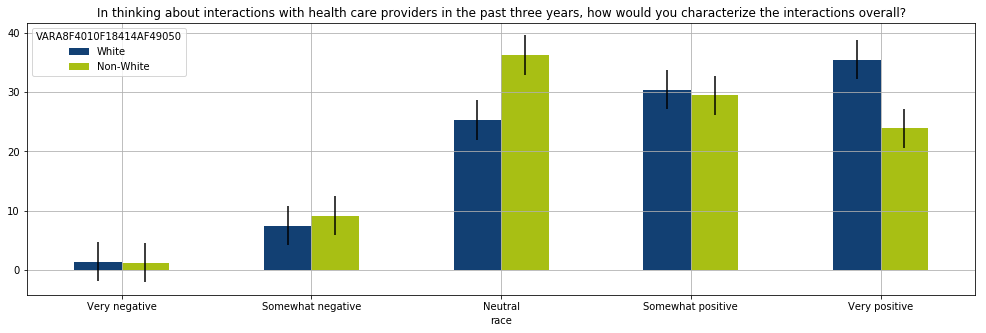

In [5]:
fig = make_plot("q32", "In thinking about interactions with health care providers in the past three years, how would you characterize the interactions overall?")
plt.savefig("images_analysis/q32.png")

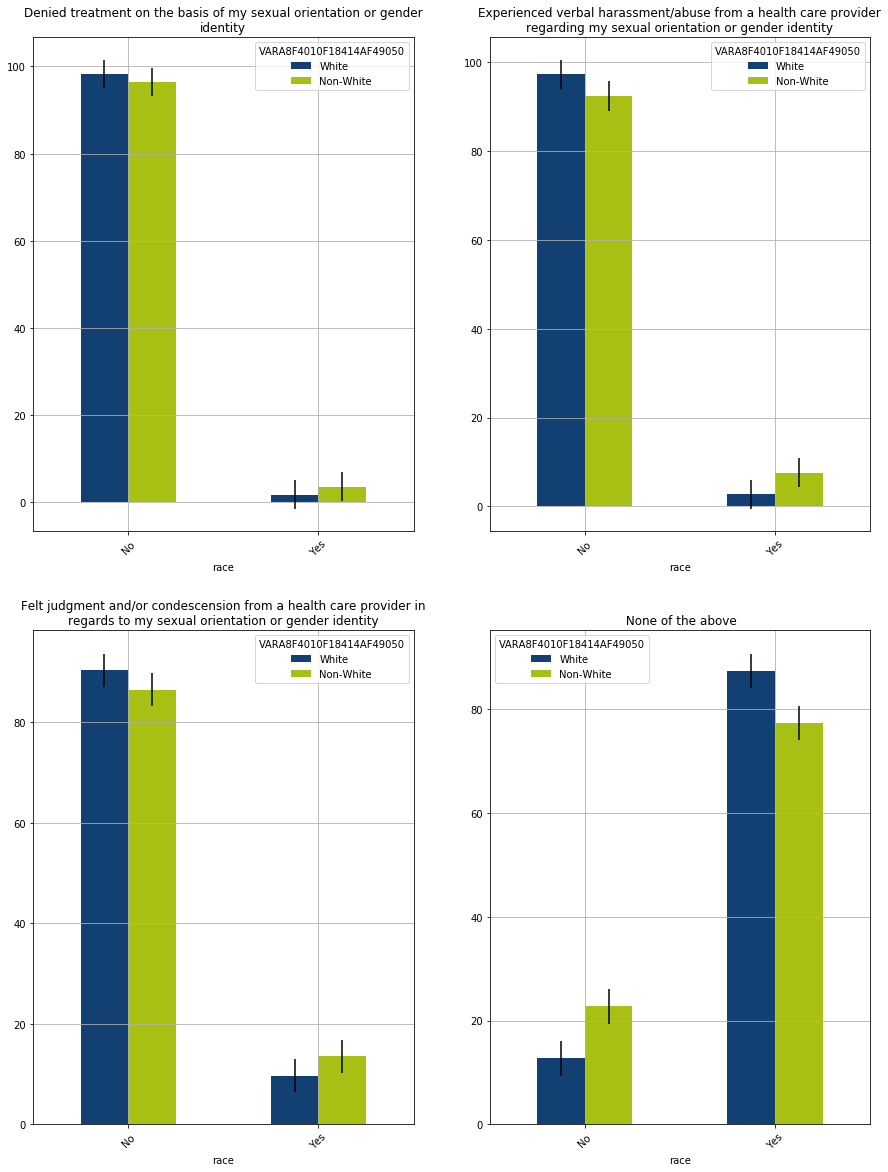

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,20))
make_subplot("q33_1", "Denied treatment on the basis of my sexual orientation or gender identity", 0, 0)
make_subplot("q33_2", "Experienced verbal harassment/abuse from a health care provider regarding my sexual orientation or gender identity", 0, 1)
make_subplot("q33_3", "Felt judgment and/or condescension from a health care provider in regards to my sexual orientation or gender identity", 1, 0)
make_subplot("q33_4", " None of the above", 1, 1)
fig.savefig("images_analysis/q33.png")

In [7]:
def make_table_multiple_parts(question):
    test = survey_table(question).reset_index()
    test.columns = test.columns.get_level_values(0)
    test.columns = ["race", "no", "yes", "total"]
    test = pd.pivot_table(test, values= ["yes"],
                               columns=["race"], aggfunc=sum)
    test= test.reset_index()
    test["index"] = question
    test.columns = ["Question", "POC", "White"]
    return(test)

def make_df_from_sub_questions(df, *args):
    for question in args:
        one_question = make_table_multiple_parts(question)
        df = df.append(one_question)
    return(df)

def make_multiple_bars_from_sub_questions(question, title, fname, height, y_tick):
    fig = question.plot.barh(figsize=(15,height)).get_figure()
    plt.xlabel('Percent', fontsize=18)
    plt.ylabel('')
    plt.yticks(fontsize= y_tick)

    plt.title(title, fontsize=30)

    fig.savefig(fname,bbox_inches='tight')

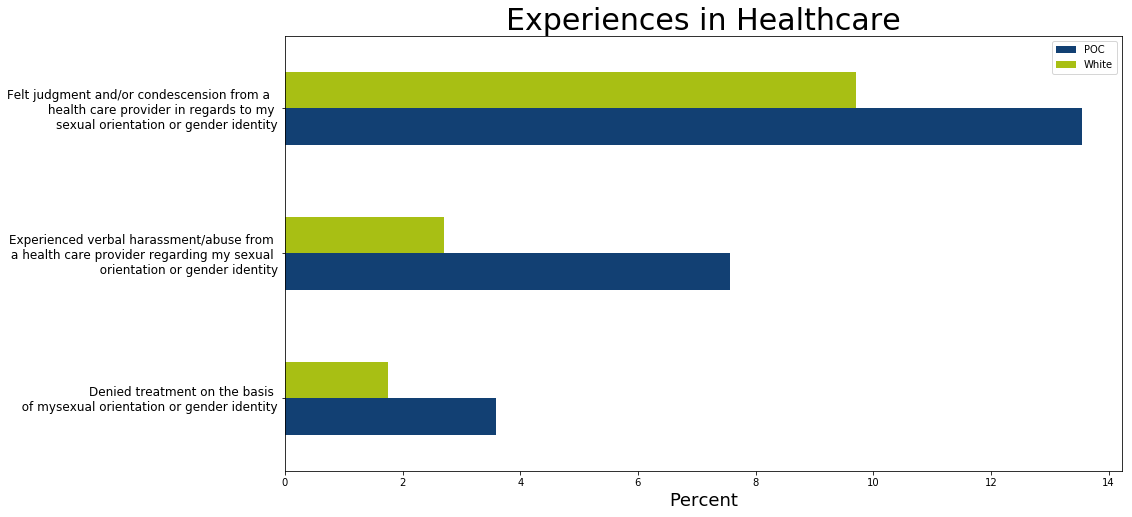

In [8]:
question = pd.DataFrame()
q33 = make_df_from_sub_questions(question,"q33_1", "q33_2", "q33_3")
q33.reset_index()
q33["index"] = [
    "Denied treatment on the basis \n  of mysexual orientation or gender identity",
    "Experienced verbal harassment/abuse from \n a health care provider regarding my sexual \n  orientation or gender identity",
    "Felt judgment and/or condescension from a  \n health care provider in regards to my \nsexual orientation or gender identity",    
]
q33 = q33.set_index("index")

make_multiple_bars_from_sub_questions(q33, "Experiences in Healthcare", "images_analysis/q33.png", height = 8, y_tick = 12)

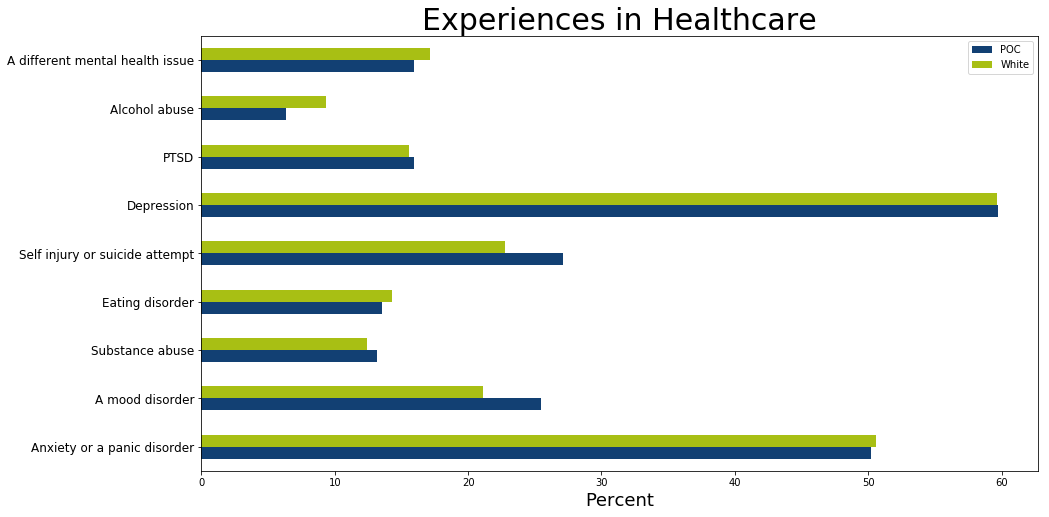

In [9]:
question = pd.DataFrame()
q41 = make_df_from_sub_questions(question,
                                 "q41_1", "q41_2", "q41_3", "q41_4",
                                "q41_5", "q41_6", "q41_7","q41_8",
                                "q41_9")
q41.reset_index()
q41["index"] = ["Anxiety or a panic disorder", "A mood disorder", "Substance abuse",
                "Eating disorder", "Self injury or suicide attempt", "Depression",
                "PTSD", "Alcohol abuse", "A different mental health issue", 
]
q41 = q41.set_index("index")

make_multiple_bars_from_sub_questions(q41, "Experiences in Healthcare", "images_analysis/mental_health.png", height = 8, y_tick = 12)

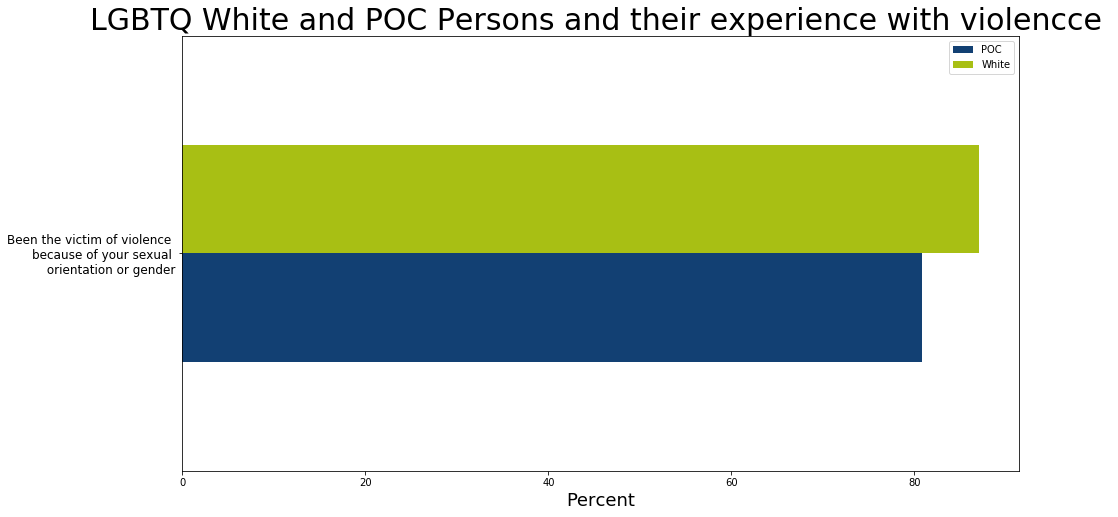

In [10]:
question = pd.DataFrame()
q42b = make_df_from_sub_questions(question, "q42b")
q42b.reset_index()
q42b["index"] = ["Been the victim of violence \nbecause of your sexual \n orientation or gender" 
]
q42b =q42b.set_index("index")

make_multiple_bars_from_sub_questions(q42b, "LGBTQ White and POC Persons and their experience with violencce ", "images_analysis/mental_health.png", height = 8, y_tick = 12)

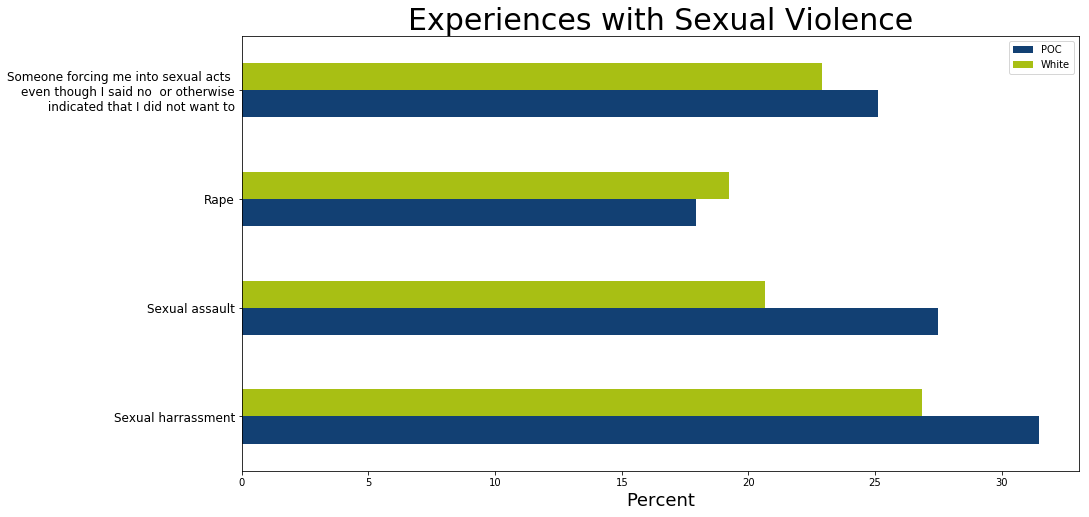

In [11]:
question = pd.DataFrame()
q42 = make_df_from_sub_questions(question,
                                 "q42_1", "q42_2", "q42_3", "q42_4")
q42.reset_index()
q42["index"] = ["Sexual harrassment", "Sexual assault", "Rape", 
                "Someone forcing me into sexual acts \neven though I said no  or otherwise\n indicated that I did not want to"
               ]
                
q42 = q42.set_index("index")

make_multiple_bars_from_sub_questions(q42, "Experiences with Sexual Violence", "images_analysis/sexual_violence.png", height = 8, y_tick = 12)

## Statistical Significance

In [12]:
def make_df_from_sub_questions(df, list_of_arguments):
    for question in list_of_arguments:
        one_question = make_table_multiple_parts(question)
        df = df.append(one_question)
    return(df)

def get_significance(discrimination_questions):
    final_df = pd.DataFrame()
    question = pd.DataFrame()
    sig = pd.DataFrame(columns = ["Question", "Significant", "P-value", "id"])
    for survey_question in discrimination_questions:
        arguments = df.columns[df.columns.str.match(survey_question)]
        result_df = make_df_from_sub_questions(question,
                                 arguments)
        result_df.reset_index()
        
        result_df["id"] = result_df["Question"]
        result_df["Question"] = result_df.Question.map( key_zip )
        
        final_df = final_df.append(result_df)
    final_df.iloc[:,1] = pd.to_numeric(final_df.iloc[:,1]) * 265 / 100
    final_df.iloc[:,2] = pd.to_numeric(final_df.iloc[:,2]) * 658 / 100

    final_df= final_df.reset_index()
    for index, row in final_df.iterrows():
        poc = final_df.iloc[index,2]
        white = final_df.iloc[index,3]
        sig_df = pd.DataFrame({"obs" : [poc, white], "nobs" : [num_poc,num_white]})
        
        stat, pval = ssp.proportions_ztest(count=sig_df["obs"], nobs=sig_df["nobs"], alternative='larger')
        question = final_df.iloc[index,1]
        result_id = final_df.iloc[index,4]
        if pval < alpha:     
            sig_answer = 'Statistically significantly'
            pval  = pval
        else:
            sig_answer = 'NOT Statistically significantly'
            pval = pval
        result = [[question, sig_answer, pval, result_id]]
        sig = sig.append(pd.DataFrame(result, columns=["Question", "Significant", "P-value", "id"]), ignore_index=True)


    return(sig)

          
#q42 = q42.set_index("index")

#make_multiple_bars_from_sub_questions(q42, "Experiences with Sexual Violence", "images_analysis/sexual_violence.png")
            


In [13]:
yes_no_discrimination_questions = ["q33", "q42", "q42a",  "q44", "q47a", "q47b",
                           "q47c", "q47_"]

key = pd.concat([pd.DataFrame(meta.column_labels), pd.DataFrame(meta.column_names)], axis = 1)
key.columns = ["name", "id"]
key_zip = dict(zip(key.id, key.name))


In [14]:
pd.set_option('display.max_colwidth', 0)

sig = get_significance(yes_no_discrimination_questions)
sig = sig.sort_values("Significant", ascending= False)
#final_df.to_csv("statistical_significance.csv")
significant = sig.loc[sig["Significant"] == "Statistically significantly" ]
significant

,Question,Significant,P-value,id
0,"In thinking about interactions with health care providers in the past three years, have you experienced... - Denied treatment on the basis of my sexual orientation or gender identity",Statistically significantly,0.045044,q33_1
1,"In thinking about interactions with health care providers in the past three years, have you experienced... - Experienced verbal harassment/abuse from a health care provider regarding my sexual orientation or gender identity",Statistically significantly,0.000367,q33_2
37,"Have you ever been denied equal treatment or service, verbally harassed, or physically attacked at any of the following on the basis of your sexuality... - Public restroom",Statistically significantly,0.035537,q47_12
36,"Have you ever been denied equal treatment or service, verbally harassed, or physically attacked at any of the following on the basis of your sexuality... - Legal services from an attorney, clinic, or legal professional",Statistically significantly,0.043937,q47_11
33,"Have you ever been denied equal treatment or service, verbally harassed, or physically attacked at any of the following on the basis of your sexuality... - Nursing home or extended care facility",Statistically significantly,0.014576,q47_8
32,"Have you ever been denied equal treatment or service, verbally harassed, or physically attacked at any of the following on the basis of your sexuality... - Department of Motor Vehicles (DMV)",Statistically significantly,0.043265,q47_7
26,"Have you ever been denied equal treatment or service, verbally harassed, or physically attacked at any of the following on the basis of your sexuality... - Public transportation",Statistically significantly,0.001402,q47_1
21,"Please indicate which of the following you have experienced in the workplace in the past 10 years, in regards to your orientation or identity. - Had limited or inadequate healthcare coverage relating to LGBTQ issues",Statistically significantly,0.019353,q44_11
6,Have you ever experienced any of the following? - Sexual assault,Statistically significantly,0.012536,q42_2
2,"In thinking about interactions with health care providers in the past three years, have you experienced... - Felt judgment and/or condescension from a health care provider in regards to my sexual orientation or gender identity",Statistically significantly,0.044140,q33_3


In [19]:
len(significant)

10

In [15]:
significant.iloc[:,3]

0     q33_1 
1     q33_2 
37    q47_12
36    q47_11
33    q47_8 
32    q47_7 
26    q47_1 
21    q44_11
6     q42_2 
2     q33_3 
Name: id, dtype: object

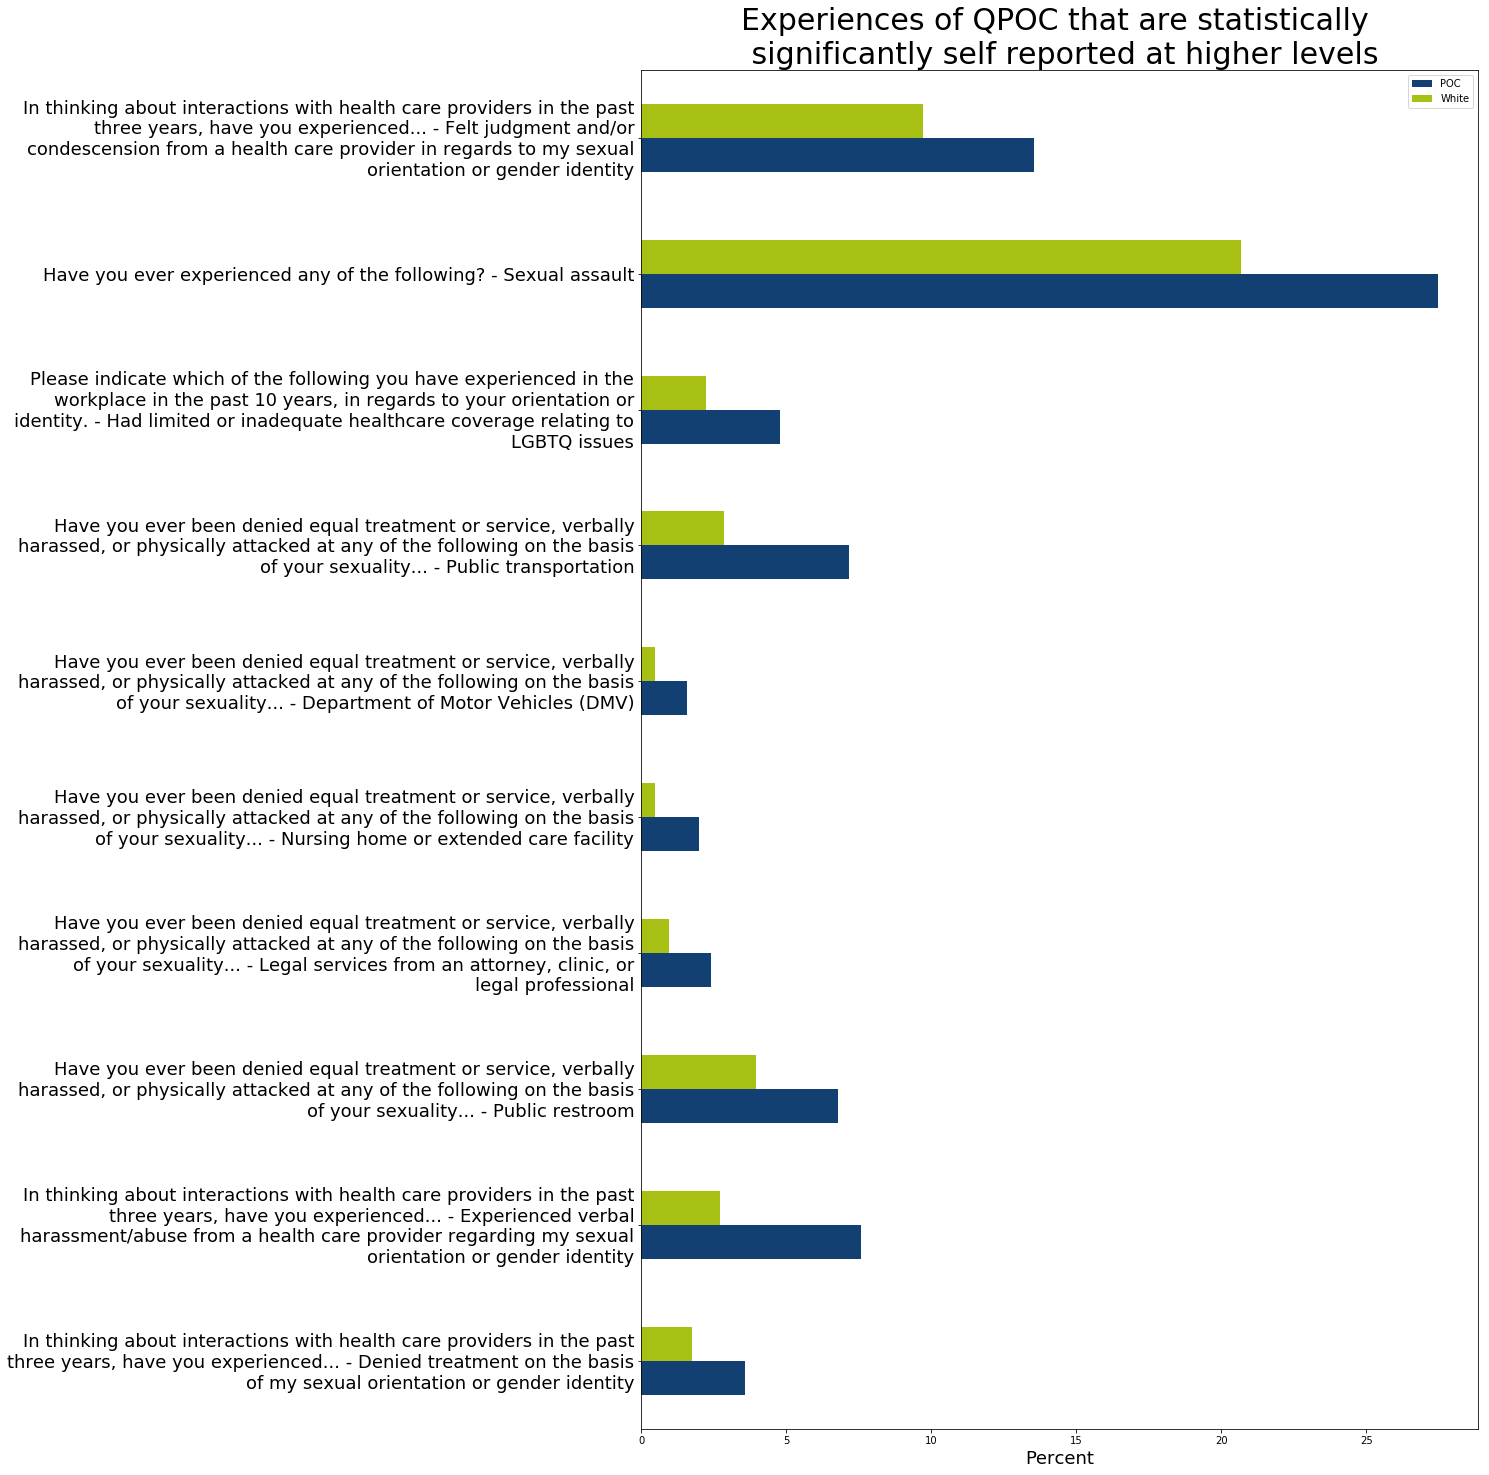

In [16]:
import textwrap

question = pd.DataFrame()
q42 = make_df_from_sub_questions(question,
                                 significant.iloc[:,3].values)
q42.reset_index()
labels = significant.iloc[:,0]
labels = [ '\n'.join(wrap(l, 70)) for l in labels ]
labels
q42["index"] = labels
q42 = q42.set_index("index")


make_multiple_bars_from_sub_questions(q42, "Experiences of QPOC that are statistically \n significantly self reported at higher levels", "images_analysis/significance.png", height = 25, y_tick = 18)


In [ ]:
def make_df_from_sub_questions(df, list_of_arguments):
    for question in list_of_arguments:
        one_question = make_table_multiple_parts(question)
        df = df.append(one_question)
    return(df)